# Project 17: Time Series
Sweet Lift Taxi company has collected historical data on taxi orders at
airports. To attract more drivers during peak hours, we need to build a model that would predict the
amount of taxi orders for the next hour.

In [1]:
!pip install --upgrade seaborn --q

In [2]:
!pip install -U -q scikit-learn

In [3]:
!pip install -U -q DateTime

In [4]:
!pip install -U -q pandas

In [5]:
#basics
import pandas as pd
import numpy as np
from timeit import default_timer as timer

#visual
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#time series
from statsmodels.tsa.seasonal import seasonal_decompose
# data preparations
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
#models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
#metrics
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<a id='0'></a>

# Table of contents
1. [Prepare the data](#1)
    - Downlad the data
    - Fix data types
    - Check for missing or duplicated values
    - Resample data
2. [Analyze the data](#2)
    - Plot graph of hourly orders and rolling mean
    - Plot graphs of orders trend and seasonality. Dayly and hourly.
    - Summary
3. [Train Models and Evaluate their performance](#3)
    - Extract features
    - Split to train and test sets
    - Train models
4. [Conclusions](#4)

<a id='1'></a>

## Prepare the data

Download small sample of data to analyze data types and fix them on the stage of loading data set

In [7]:
OSX_path = '/Users/stainer/Desktop/Jupyter/Project_17 Time Series'
try:
    data = pd.read_csv(OSX_path+'/taxi.csv', nrows=10)
except:
    data = pd.read_csv('/datasets/taxi.csv', nrows=10)

In [8]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [9]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    10 non-null     object
 1   num_orders  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


Download full data set, parsing dates to datetime type and using it as index

In [11]:
try:
    data = pd.read_csv(OSX_path+'/taxi.csv', parse_dates=['datetime'], index_col='datetime')
except:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [12]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Check for missing values

In [14]:
data.isna().sum()

num_orders    0
dtype: int64

Check for duplicated values

In [15]:
data.duplicated().sum()

26415

Resample data, using total number of orders per hour<br>
Check whether dates that we use as index are continuous

In [16]:
data = data.resample('1H').sum()

In [17]:
data.index.is_monotonic

True

__Summary:__<br>
Data was sucessfully loaded with fixed data types, inspected for missing and duplicated values

<a id='2'></a>

## Analyze the data

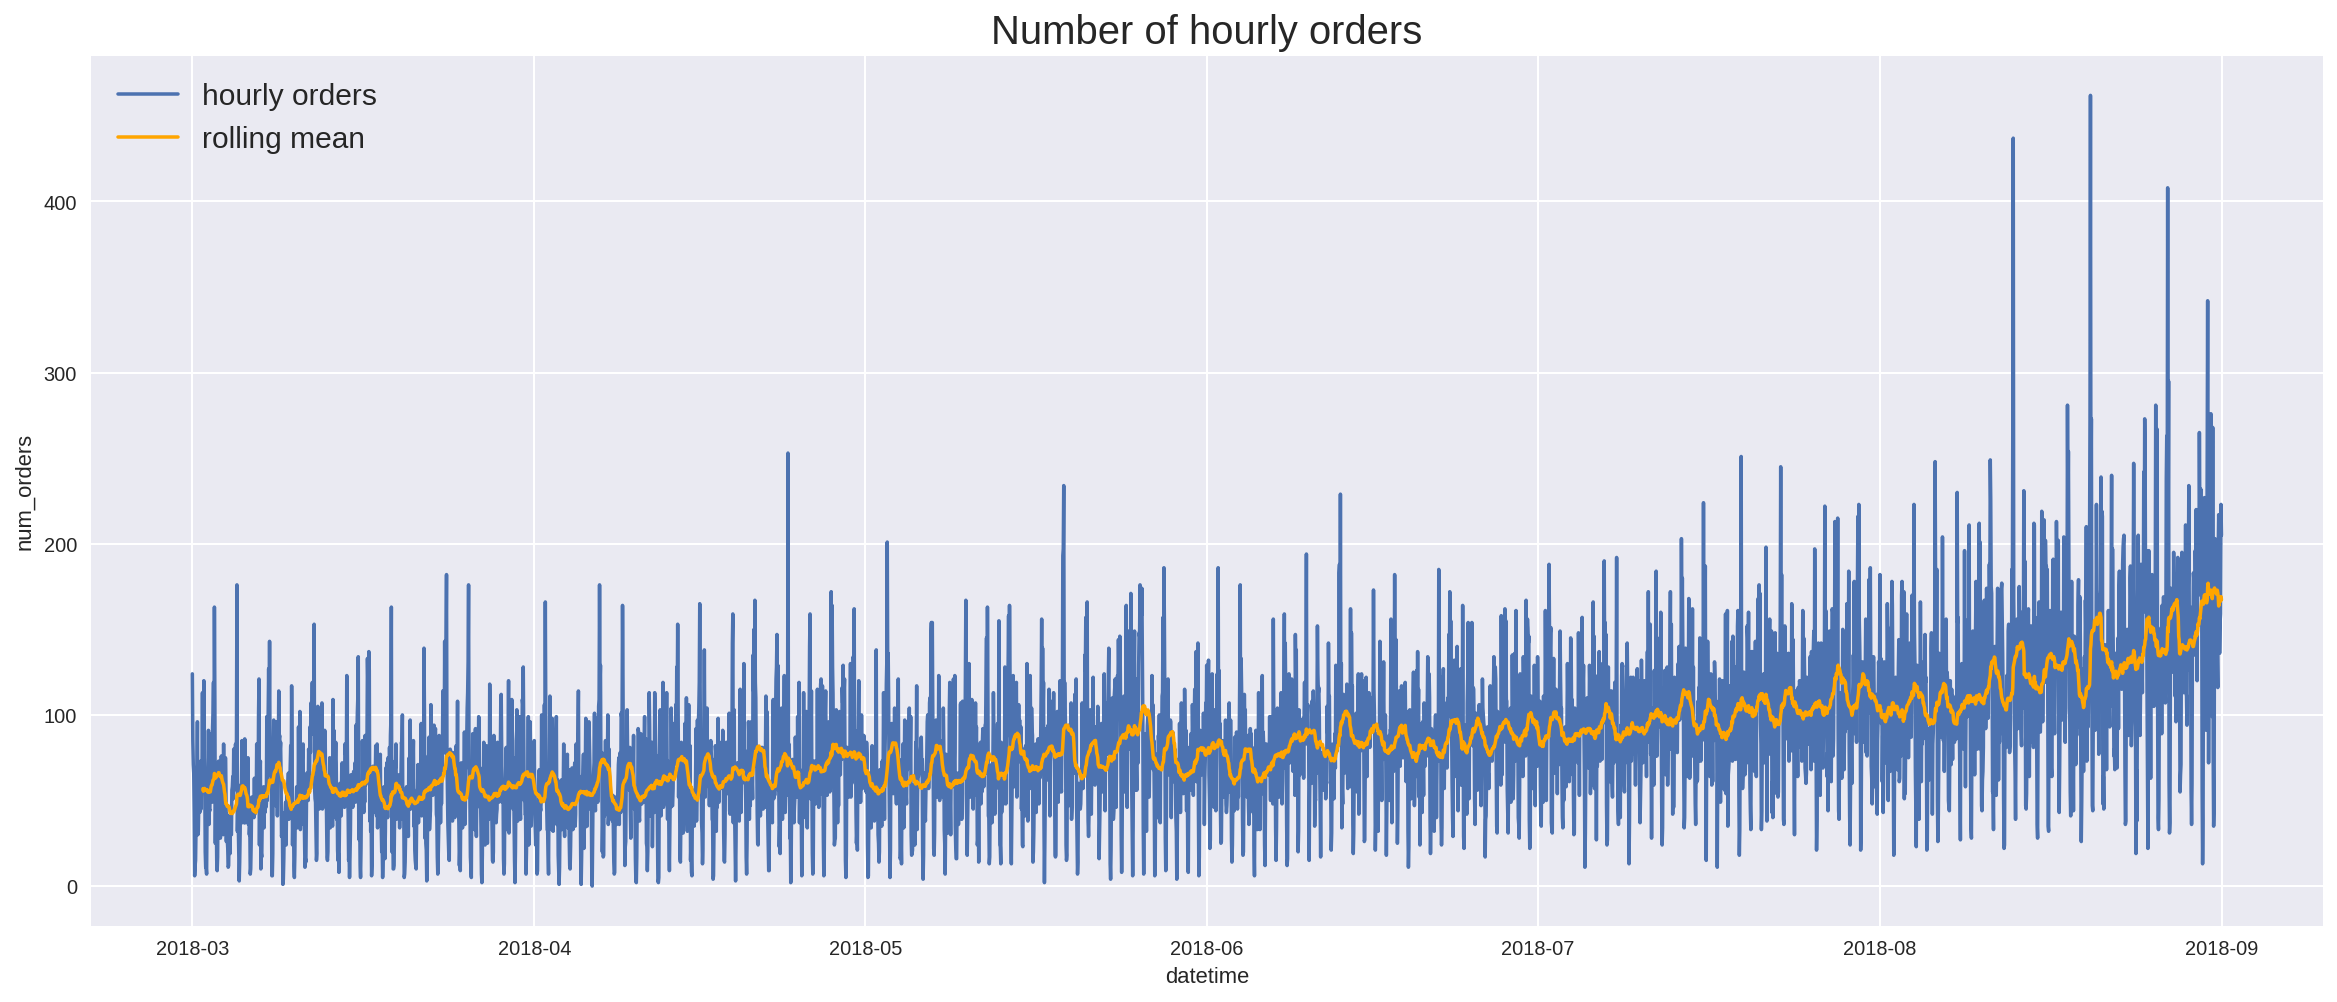

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(y='num_orders', x='datetime', data=data, label='hourly orders')
sns.lineplot(y=data['num_orders'].rolling(24).mean(), x='datetime', data=data, color='orange', label='rolling mean')
ax.set_title("Number of hourly orders", fontsize=20)
plt.legend(fontsize=15);

Number of orders fluctuates heavily every hour.<br>
We also can see that number of orders gradually increases throughout recorded months

In [19]:
decomposed_hourly = seasonal_decompose(data['num_orders'])
decomposed_daily = seasonal_decompose(data.resample('1D').sum()['num_orders'])

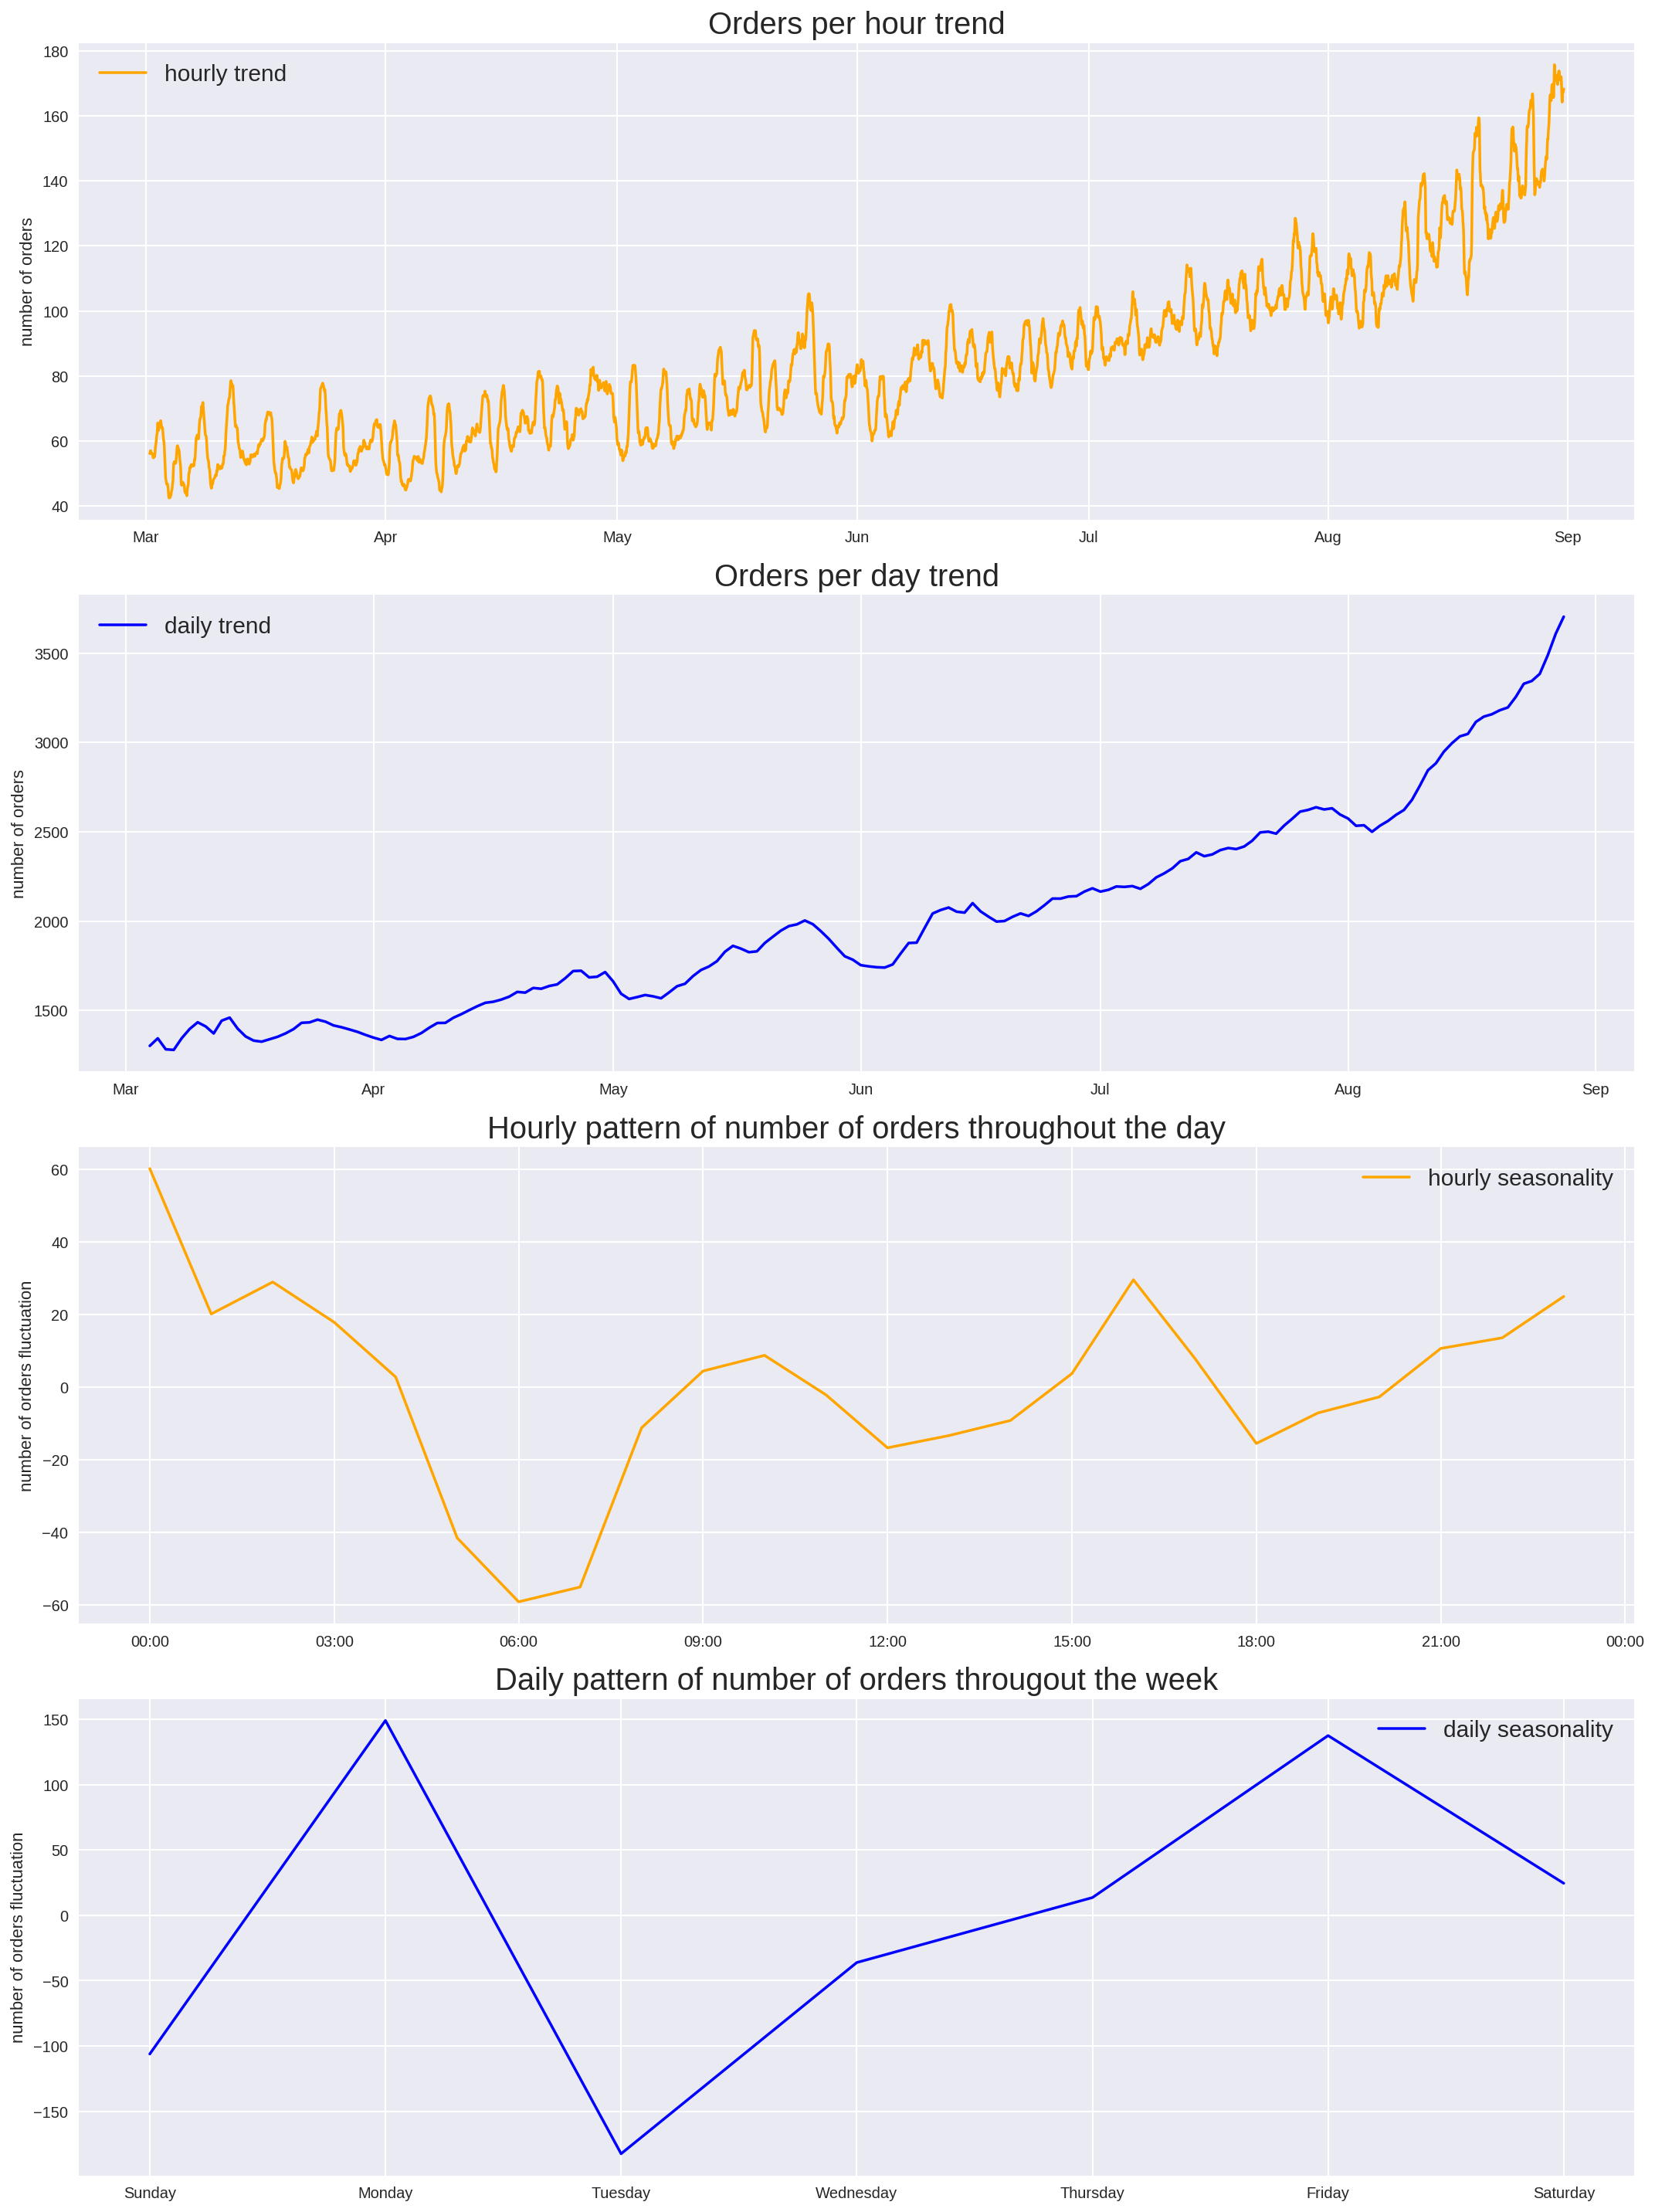

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(15,20))

sns.lineplot(data=decomposed_hourly.trend, color='orange', label='hourly trend',ax=axs[0])
axs[0].set_title('Orders per hour trend', fontsize=20)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%h"))

sns.lineplot(data=decomposed_daily.trend, color='blue', label='daily trend',ax=axs[1])
axs[1].set_title('Orders per day trend', fontsize=20)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%h"))

sns.lineplot(data=decomposed_hourly.seasonal['2018-04-01':'2018-04-01'], color='orange', label='hourly seasonality', ax=axs[2])
axs[2].set_title('Hourly pattern of number of orders throughout the day', fontsize=20)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

sns.lineplot(data=decomposed_daily.seasonal['2018-04-01':'2018-04-07'], color='blue', label='daily seasonality', ax=axs[3]);
axs[3].set_title('Daily pattern of number of orders througout the week', fontsize=20)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%A"))

[(ax.legend(fontsize=15), ax.set_xlabel('')) for ax in axs]
[axs[i].set_ylabel('number of orders') for i in [0,1]]
[axs[i].set_ylabel('number of orders fluctuation') for i in [2,3]]

plt.tight_layout()

Number of orders steadily rises throughout observes months<br>
There is a daily and hourly pattern, how number of orders is changing <br>
- Orders peaking around midnight and at the begining and end of office working hours
- Lowest number of orders is in the early morning, around 6AM
- Mondays and Fridays are the busiest days
- Sundays and Tuesdays have the lowest number of cabs ordered 

<a id='3'></a>

## Train models

In [28]:
def extract_features(data, rolling_slice, lag_shift):
    features = {}
    features['month'] = data.index.month
    features['week'] = data.index.isocalendar().week
    features['weekday'] = data.index.isocalendar().day
    features['day'] = data.index.day
    features['hour'] = data.index.hour
        
    for lag_index in range(1, lag_shift+1):
        features[f"lag_{lag_index}"] = data['num_orders'].shift(lag_index)
    
    features['rolling_mean'] = data['num_orders'].shift().rolling(rolling_slice).mean()
   
    return pd.DataFrame(features, index=data.index), data['num_orders']

In [29]:
features, target = extract_features(data, 10, 10)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

Function for model evaluation<br>
Return rmse scores for train and test sets as dictionary

In [45]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_predictions = model.predict(X_train.to_numpy())
    begin = timer()
    test_predictions = model.predict(X_test.to_numpy())
    end = timer()
#     print("MAE for the training set:", mean_absolute_error(y_train, train_predictions))
#     print("MAE for the test set: ", mean_absolute_error(y_test, test_predictions))
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
    print(f"RMSE for training set: {train_rmse:.2f}")
    print(f"RMSE for test set: {test_rmse:.2f}")
    return {'train_rmse':train_rmse, 'test_rmse':test_rmse, 'pred_time':end-begin}

In [46]:
results = {}

### Linear Regression

In [47]:
lr = LinearRegression()
begin = timer()
lr.fit(X_train, y_train)
end = timer()
results['Linear Regression'] = evaluate_model(lr, X_train, X_test, y_train, y_test)
results['Linear Regression']['train_time'] = end - begin

RMSE for training set: 30.22
RMSE for test set: 53.70


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


### Lasso

In [48]:
lasso = Lasso()
begin = timer()
lasso.fit(X_train, y_train)
end = timer()
results['Lasso'] = evaluate_model(lasso, X_train, X_test, y_train, y_test)
results['Lasso']['train_time'] = end - begin

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


RMSE for training set: 30.23
RMSE for test set: 53.45


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


Function to perform GridSearchCV algorithm with given parameters<br>
Return best parameters

In [49]:
def grid_params(model, params, features, target):
    model = GridSearchCV(model, params, cv=TimeSeriesSplit(n_splits=4), scoring='neg_mean_squared_error', verbose=1)
    model.fit(X_train.to_numpy(), y_train.to_numpy())
    return model.best_params_

### DecisionTreeRegressor

In [50]:
params = {'max_depth':range(3, 16, 1)}
begin = timer()
best_params = grid_params(DecisionTreeRegressor(random_state=RANDOM_STATE), params, X_train, y_train)
print(best_params)

dtr = DecisionTreeRegressor(random_state=RANDOM_STATE, **best_params)
dtr.fit(X_train, y_train)
end = timer()

results['DecisionTreeRegressor'] = evaluate_model(dtr, X_train, X_test, y_train, y_test)
results['DecisionTreeRegressor']['train_time'] = end - begin

Fitting 4 folds for each of 13 candidates, totalling 52 fits
{'max_depth': 7}
RMSE for training set: 21.40
RMSE for test set: 50.10


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


### RandomForestRegressor

In [51]:
params = {'max_depth':range(3, 16, 2), 'n_estimators':range(50, 100, 15)}
begin = timer()
best_params = grid_params(RandomForestRegressor(random_state=RANDOM_STATE), params, X_train, y_train)
print(best_params)

rfr = RandomForestRegressor(random_state=RANDOM_STATE, **best_params)
rfr.fit(X_train, y_train)
end = timer()

results['RandomForestRegressor'] = evaluate_model(rfr, X_train, X_test, y_train, y_test)
results['RandomForestRegressor']['train_time'] = end - begin

Fitting 4 folds for each of 28 candidates, totalling 112 fits
{'max_depth': 15, 'n_estimators': 95}
RMSE for training set: 9.52
RMSE for test set: 43.67


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


### GradientBoostingRegressor

In [52]:
params = {'learning_rate':np.arange(0.05, 0.4, 0.05)}
begin = timer()
best_params = grid_params(GradientBoostingRegressor(random_state=RANDOM_STATE), params, X_train, y_train)
print(best_params)

gbr = GradientBoostingRegressor(random_state=RANDOM_STATE, **best_params)
gbr.fit(X_train, y_train)
end = timer()

results['GradientBoostingRegressor'] = evaluate_model(gbr, X_train, X_test, y_train, y_test)
results['GradientBoostingRegressor']['train_time'] = end - begin

Fitting 4 folds for each of 7 candidates, totalling 28 fits
{'learning_rate': 0.1}
RMSE for training set: 20.04
RMSE for test set: 46.45


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


### CatBoostRegressor

In [53]:
params = {'learning_rate':np.arange(0.05, 0.4, 0.05), 'verbose':[0]}
begin = timer()
best_params = grid_params(CatBoostRegressor(random_state=RANDOM_STATE), params, X_train, y_train)
print(best_params)

cbr = CatBoostRegressor(random_state=RANDOM_STATE, **best_params)
cbr.fit(X_train.to_numpy(), y_train.to_numpy())
end = timer()

results['CatBoostRegressor'] = evaluate_model(cbr, X_train, X_test, y_train, y_test)
results['CatBoostRegressor']['train_time'] = end - begin

Fitting 4 folds for each of 7 candidates, totalling 28 fits
{'learning_rate': 0.05, 'verbose': 0}
RMSE for training set: 12.16
RMSE for test set: 43.35


### LGBMRegressor

In [54]:
params = {'learning_rate':np.arange(0.05, 0.4, 0.05)}
begin = timer()
best_params = grid_params(LGBMRegressor(random_state=RANDOM_STATE), params, X_train, y_train)
print(best_params)

lbr = LGBMRegressor()
lbr.fit(X_train.to_numpy(), y_train.to_numpy())
end = timer()

results['LGBMRegressor'] = evaluate_model(lbr, X_train, X_test, y_train, y_test)
results['LGBMRegressor']['train_time'] = end - begin

Fitting 4 folds for each of 7 candidates, totalling 28 fits
{'learning_rate': 0.05}
RMSE for training set: 13.73
RMSE for test set: 42.89


In [61]:
print(f"{'model':<30}{'train rmse':>15}{'test rmse':>15}{'train time':>15}{'pred time':>15}s")
for model in results:
    print(f"{model:<30}{results[model]['train_rmse']:>15.2f}{results[model]['test_rmse']:>15.2f}{results[model]['train_time']:>15.2f}s{results[model]['pred_time']:>15.4f}")

model                              train rmse      test rmse     train time      pred times
Linear Regression                       30.22          53.70           0.00s         0.0008
Lasso                                   30.23          53.45           0.11s         0.0019
DecisionTreeRegressor                   21.40          50.10           0.95s         0.0011
RandomForestRegressor                    9.52          43.67          78.71s         0.0128
GradientBoostingRegressor               20.04          46.45          14.13s         0.0017
CatBoostRegressor                       12.16          43.35         431.98s         0.0027
LGBMRegressor                           13.73          42.89          30.59s         0.0882


<a id='4'></a>

## Conclusions
- We've downloaded the data, fixing data types
- Analyzed data, looking for patterns and trends in how number of orders change
    - Overall increase in number of orders with time
    - Hourly and daily patterns in customers behaviour
- Trained couple of models, performing basic hyperparameter adjustments

Out of seven models that we trained only one~~, Decision Tree Regressor does not meet required standart (rmse<48)~~<br>

Now this makes a lot more sence. Linear models and Decision tree fail to meet our project requirement.<br>
Leaving that aside.
- LGBMRegressor is quick to train with most accurate predictions, but prediction time is pretty slow.
- If we are willing to scrifise a bit of accuracy for 